Seek his will in all you do, and he will show you which path to take.
Proverbs 3:6

Use QAOA to verify the partitioning of neurons by cortical depth.


## Data Loading

In [1]:
import numpy as np
import pandas as pd
from numba import njit
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
from scipy import stats, signal
from scipy.spatial.distance import pdist, squareform
from scipy.cluster import hierarchy
from scipy.stats import binomtest, binned_statistic, zscore 
from scipy.optimize import curve_fit
from sklearn.decomposition import PCA, NMF
from sklearn.cluster import DBSCAN, KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mutual_info_score  
from sklearn.metrics import silhouette_score
from sklearn.impute import SimpleImputer
import networkx as nx
from tqdm import tqdm
import pickle


# Import new meta-assembly modules
from qaoa.pipelines.meta_assembly import run_meta_qaoa, MetaAssemblyConfig
from qaoa.runners import get_ionq_aria_backend
from assembly import soft_cluster_neurons, find_optimal_k, build_assembly_graph
from analysis.validation import validate_meta_assembly, hamming_cluster
from features import pearson_corr_matrix as corr_fn

# Additional imports for visualization
import json
from datetime import datetime
from IPython.display import Image, display

# Set up plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
warnings.filterwarnings('ignore')

# Import custom modules
from pathlib import Path
import sys
PROJECT_ROOT = Path().resolve().parent  
sys.path.insert(0, str(PROJECT_ROOT))

from src.dataio.config import DATA_DIR, FILESYSTEM_CONFIG
from src.dataio.data_structures import SessionData
from src.dataio.loaders import load_session_complete
from src.dataio.processors import ResponseProcessor, NetworkAnalyzer, DimensionalityReducer
from src.dataio.validators import validate_session_comprehensive, analyze_session_quality
from src import features

📁 Data directory: /Volumes/pack/qbraid/neuroscience-qaoa/notebooks/data
✓ Data directory exists: True


In [2]:
DATA_DIR = Path('../data/raw')

# Find all subdirs that contain the expected .mat file
MAT_FILENAME = 'allPlanesVariables27-Feb-2021.mat'
sessions = sorted([
    d.name
    for d in DATA_DIR.iterdir()
    if d.is_dir() and (d / MAT_FILENAME).is_file()
])

print(f"Discovered {len(sessions)} sessions:")
for s in sessions:
    print("  ", s)

# Choose your primary session here (must be one of the discovered names)
PRIMARY_SESSION = '081820_355n'
if PRIMARY_SESSION not in sessions:
    raise ValueError(f"Primary session '{PRIMARY_SESSION}' not found in data/. Available: {sessions}")

print(f"\nPrimary analysis session: {PRIMARY_SESSION}")

# --- now load & process as before ---

session_path = DATA_DIR / PRIMARY_SESSION
print(f"Loading session from: {session_path}")

session = load_session_complete(session_path, use_cache=True)
session.normalized_traces = zscore(session.activity_matrix, axis=1)

validation_result = validate_session_comprehensive(session)
quality_report     = analyze_session_quality(session)

print(f"\nSession loaded successfully!")
print(f"Neurons: {len(session.neurons)}")
print(f"Trials:  {len(session.trials)}")
print(f"Activity matrix shape: {session.activity_matrix.shape}")
print(f"Data quality score: {quality_report['overall_score']:.2f}")


Discovered 9 sessions:
   031020_367n_100um20st_FRA
   031020_367r_100um20st_FRA
   031120_352ll_100um20st_FRA
   031120_352ll_100um20st_FRA_diffxy
   080720_400r
   081820_355n
   081920_355l
   081920_355r
   082620_355l

Primary analysis session: 081820_355n
Loading session from: ../data/raw/081820_355n


VALIDATION WARNING: Unexpected trial count: 22. Expected one of [90, 180]
VALIDATION WARNING: Activity matrix contains 4 NaN values (0.00%).



Session loaded successfully!
Neurons: 416
Trials:  22
Activity matrix shape: (416, 2060)
Data quality score: 1.00


## QAOA Meta Assembly

### Phase 1: Classical Pre-processing

Computing correlation matrix...


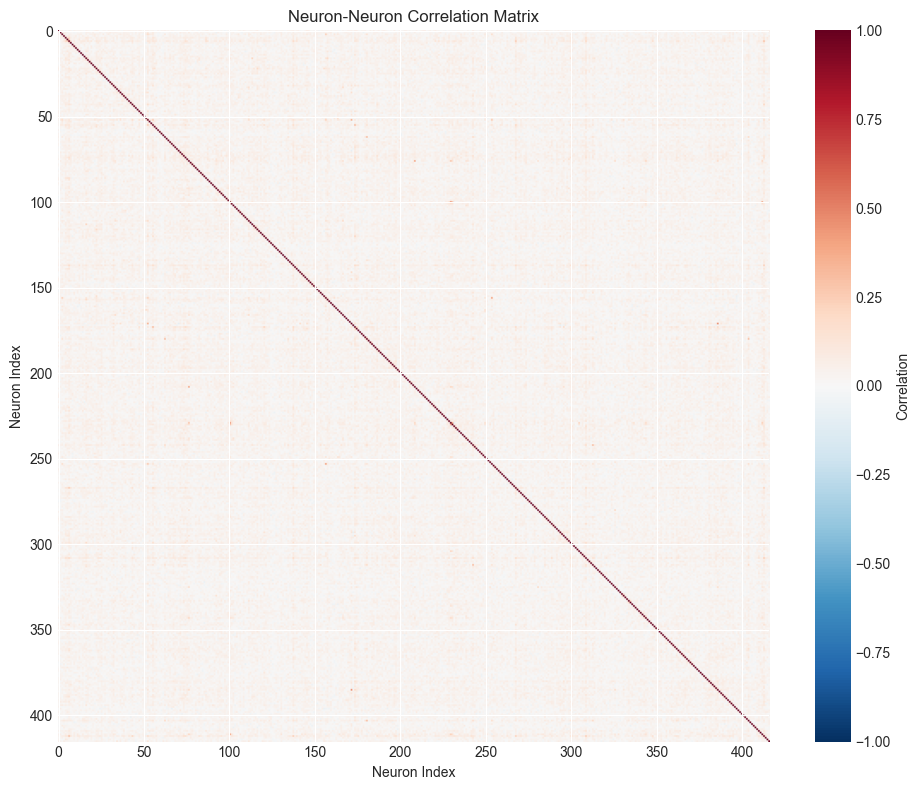

Finding optimal number of assemblies...


Finding optimal k: 100%|██████████| 16/16 [00:00<00:00, 244.29it/s]

Optimal number of assemblies: 60
Performing soft clustering with k=50 assemblies...


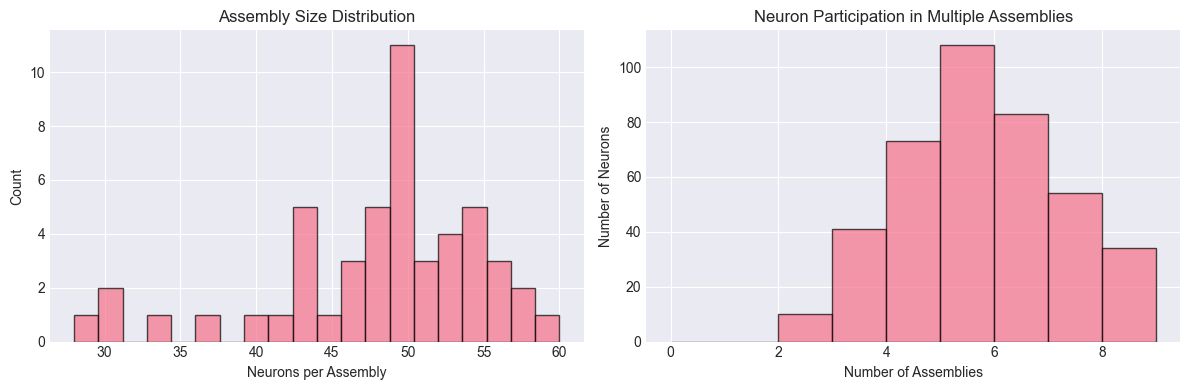

Average neurons per assembly: 48.0
Average assemblies per neuron: 5.8


In [3]:
# Compute correlation matrix
print("Computing correlation matrix...")
corr_matrix = features.pearson_corr_matrix(session.activity_matrix)

# Visualize correlation structure
plt.figure(figsize=(10, 8))
plt.imshow(corr_matrix, cmap='RdBu_r', vmin=-1, vmax=1)
plt.colorbar(label='Correlation')
plt.title('Neuron-Neuron Correlation Matrix')
plt.xlabel('Neuron Index')
plt.ylabel('Neuron Index')
plt.tight_layout()
plt.show()

# %% [markdown]
# ### Determine Optimal Number of Assemblies

# %%
# Find optimal k using silhouette analysis
print("Finding optimal number of assemblies...")
k_optimal = find_optimal_k(corr_matrix, k_min=30, k_max=60)
print(f"Optimal number of assemblies: {k_optimal}")

# We can override this if needed based on biological constraints
k_target = 50  # Use 50 assemblies for ~400 neurons

# %%
# Perform soft clustering to identify assemblies
print(f"Performing soft clustering with k={k_target} assemblies...")
traces = zscore(session.activity_matrix, axis=1)
traces = SimpleImputer(strategy="median").fit_transform(traces)
session.normalized_traces = traces

membership_matrix = soft_cluster_neurons(session, k_override=k_target)

# Analyze assembly properties
assembly_sizes = np.sum(membership_matrix, axis=1)
neurons_per_assembly = [np.sum(membership_matrix[i, :]) for i in range(k_target)]

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.hist(neurons_per_assembly, bins=20, edgecolor='black', alpha=0.7)
plt.xlabel('Neurons per Assembly')
plt.ylabel('Count')
plt.title('Assembly Size Distribution')

plt.subplot(1, 2, 2)
# Calculate neuron participation (how many assemblies each neuron belongs to)
neuron_participation = np.sum(membership_matrix, axis=0)
plt.hist(neuron_participation, bins=np.arange(0, 10), edgecolor='black', alpha=0.7)
plt.xlabel('Number of Assemblies')
plt.ylabel('Number of Neurons')
plt.title('Neuron Participation in Multiple Assemblies')

plt.tight_layout()
plt.show()

print(f"Average neurons per assembly: {np.mean(neurons_per_assembly):.1f}")
print(f"Average assemblies per neuron: {np.mean(neuron_participation):.1f}")

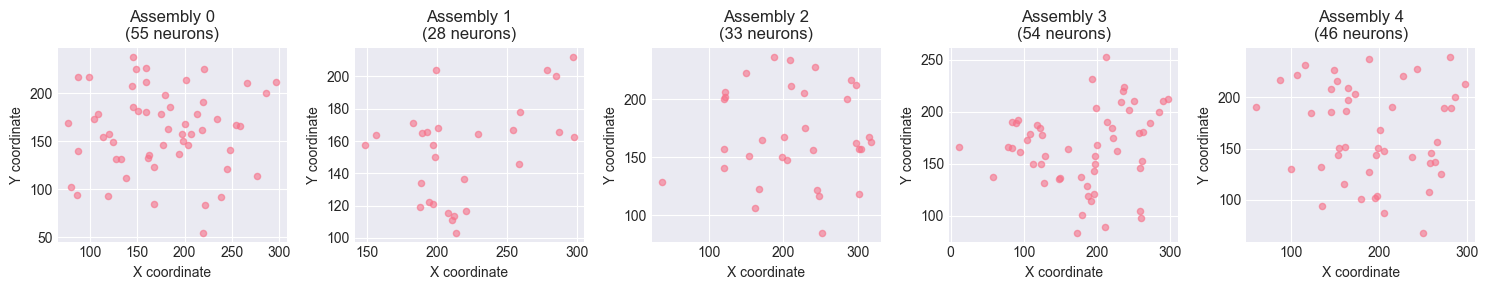

In [4]:
n_assemblies_to_show = 5

fig, axes = plt.subplots(1, n_assemblies_to_show, figsize=(15, 3))

for i in range(n_assemblies_to_show):
    ax = axes[i]
    assembly_neurons = membership_matrix[i, :]
    
    # Show spatial distribution if we have coordinates
    if hasattr(session.neurons[0], 'x'):
        x_coords = [n.x for n, is_member in zip(session.neurons, assembly_neurons) if is_member]
        y_coords = [n.y for n, is_member in zip(session.neurons, assembly_neurons) if is_member]
        ax.scatter(x_coords, y_coords, alpha=0.6, s=20)
        ax.set_title(f'Assembly {i}\n({np.sum(assembly_neurons)} neurons)')
        ax.set_xlabel('X coordinate')
        ax.set_ylabel('Y coordinate')
    else:
        # Just show membership pattern
        ax.imshow(assembly_neurons.reshape(-1, 1), aspect='auto', cmap='Blues')
        ax.set_title(f'Assembly {i}')
        ax.set_ylabel('Neuron')

plt.tight_layout()
plt.show()

Computing assembly triplet weights...


Extracting w_abc: 100%|██████████| 1140/1140 [00:00<00:00, 2681719.89it/s]

Total number of possible triplets: 19600
Number of non-zero triplets: 40


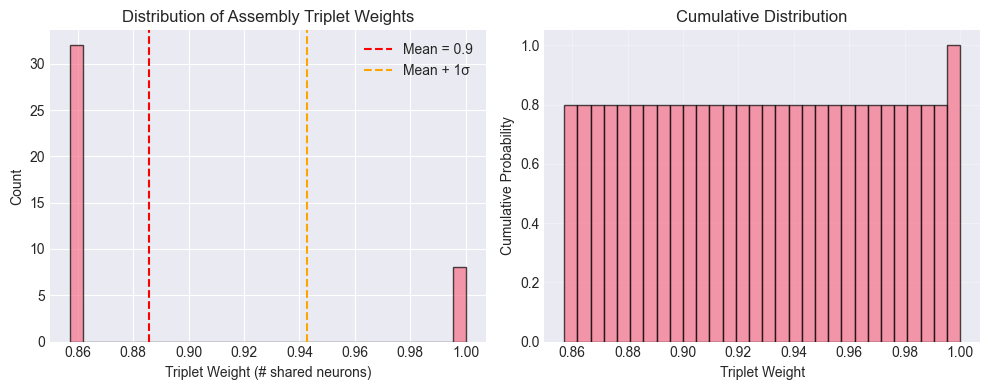

In [6]:
params = dict(
    k_assemblies=60,          # full soft‑cluster size
    select_mode="size",       # "size", "cohesion" or None
    n_select=20,              # target qubit register
    normalization_strategy="rich_club",  
    sigma_thresh=1.0,
    max_terms=2*20,           # heuristic cap
)

print("Computing assembly triplet weights...")
triplet_weights = build_assembly_graph(session, **params)

print(f"Total number of possible triplets: {k_target * (k_target-1) * (k_target-2) // 6}")
print(f"Number of non-zero triplets: {len(triplet_weights)}")

# Visualize weight distribution
if triplet_weights:
    weights = list(triplet_weights.values())
    
    plt.figure(figsize=(10, 4))
    
    plt.subplot(1, 2, 1)
    plt.hist(weights, bins=30, edgecolor='black', alpha=0.7)
    plt.xlabel('Triplet Weight (# shared neurons)')
    plt.ylabel('Count')
    plt.title('Distribution of Assembly Triplet Weights')
    plt.axvline(np.mean(weights), color='red', linestyle='--', label=f'Mean = {np.mean(weights):.1f}')
    plt.axvline(np.mean(weights) + np.std(weights), color='orange', linestyle='--', label='Mean + 1σ')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.hist(weights, bins=30, edgecolor='black', alpha=0.7, cumulative=True, density=True)
    plt.xlabel('Triplet Weight')
    plt.ylabel('Cumulative Probability')
    plt.title('Cumulative Distribution')
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

### Run Quantum Algorithm